<h2>Data gathering</h2>

I downloaded the dataset from kaggle, extracted the csv file and imported it into a Spark Dataframe.

In [ ]:
!kaggle datasets download -d patrickzel/flight-delay-and-cancellation-dataset-2019-2023
!unzip flight-delay-and-cancellation-dataset-2019-2023.zip
!pip install pyspark

Dataset URL: https://www.kaggle.com/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023
License(s): other
 99% 138M/140M [00:02<00:00, 58.4MB/s]
100% 140M/140M [00:02<00:00, 62.7MB/s]
Archive:  flight-delay-and-cancellation-dataset-2019-2023.zip
  inflating: dictionary.html         
  inflating: flights_sample_3m.csv   


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LogisticRegressionModel, RandomForestClassificationModel, GBTClassifier, \
                                      GBTClassificationModel, MultilayerPerceptronClassifier, MultilayerPerceptronClassificationModel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from time import time
from sklearn.metrics import roc_curve

from google.colab import drive
import os
import csv

drive.mount('/content/drive')

# directory in google drive to store results
dir_path = '/content/drive/MyDrive/DM_HW2/'

# create the directory if it doesn't exist
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    print(f"Directory '{dir_path}' created.")
else:
    print(f"Directory '{dir_path}' already exists.")

Mounted at /content/drive
Directory '/content/drive/MyDrive/DM_HW2/' already exists.


In [ ]:
# initialize spark session
spark = SparkSession.builder.appName('FlightData').getOrCreate()


Here we can see the fields of the schema (automatically detected from the Dataframe object with inferSchema = True).

In [ ]:
# import the dataset in a Spark Dataframe
df = spark.read.csv('/content/flights_sample_3m.csv', header=True, inferSchema=True)
df.printSchema()

print(df.count())

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)

Let's drop unuseful columns:


*   Every airline is uniquely identified by its AIRLINE_CODE (2-letters IATA code)
*   Every airport is uniquely identified by its 3-letters IATA code.

So additional strings containing the origin and destination city or the airline are dropped due to their redundancy.



In [ ]:
df = df.drop("AIRLINE", "AIRLINE_DOT", "ORIGIN_CITY", "DEST_CITY")

<h2>Initial analysis: checking NULL</h2>

There is a strong presence of NULL values, but the reason will be clear in a second.

In [ ]:
# this useful line of code computes the number of NULL values in each field
null_counts = df.select([F.sum(F.col(col).isNull().cast("int")).alias(col + "_null_count") for col in df.columns])

# Show the count of null values in each column
null_counts.show()

+------------------+-----------------------+-------------------+--------------------+-----------------+---------------+-----------------------+-------------------+--------------------+-------------------+---------------------+--------------------+------------------+-----------------------+-------------------+--------------------+--------------------+----------------------------+-------------------+---------------------------+-----------------------+-------------------+-------------------+----------------------------+----------------------------+------------------------+-----------------------------+----------------------------------+
|FL_DATE_null_count|AIRLINE_CODE_null_count|DOT_CODE_null_count|FL_NUMBER_null_count|ORIGIN_null_count|DEST_null_count|CRS_DEP_TIME_null_count|DEP_TIME_null_count|DEP_DELAY_null_count|TAXI_OUT_null_count|WHEELS_OFF_null_count|WHEELS_ON_null_count|TAXI_IN_null_count|CRS_ARR_TIME_null_count|ARR_TIME_null_count|ARR_DELAY_null_count|CANCELLED_null_count|CANCEL

Most NULL values mostly derive from diverted or canceled flights.
Matter of fact, the number of canceled or diverted flights is almost equal to the number of tuples containing NULL values (except for the fields that are mostly NULL).

Obviously, the information about the arrival delay cannot be reconstructed in such cases, therefore the tuples are dropped.

In [ ]:
canceled_or_diverted = df.filter((F.col("CANCELLED") == 1) | (F.col("DIVERTED") == 1))
print(canceled_or_diverted.count())

86196


After removing the tuples, the corresponding columns are dropped. Now there are only 2 tuples left with missing information! This can be seen by running again the null counter.

In [ ]:
df = df.filter((F.col("CANCELLED") == 0) & (F.col("DIVERTED") == 0))
df = df.drop("CANCELLED", "DIVERTED", "CANCELLATION_CODE")
print(df.count())

2913804


The only 2 tuples left with missing information have the same problems of the above cited ones, so I decided to drop them as well.
Now, running once again the null counter block, you will see that the only NULL values left are contained in the last 5 fields (which are NULL for most of the tuples).


In [ ]:
# remove the last two problematic tuples (with missing info)
df.filter(F.col("ARR_DELAY").isNull()).show()
df = df.filter(F.col("ARR_DELAY").isNotNull())
print(df.count())

+----------+------------+--------+---------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+
|   FL_DATE|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|
+----------+------------+--------+---------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+
|2023-05-21|          YX|   20452|     5612|   LGA| BNA|        1605|  1642.0|     37.0|    36.0|   

<h2> Anomaly detection </h2>

To identify anomalies, I created a function that converts numerical columns representing times of day into timestamps. The objective is to check that:
<div>time_col_2 - time_col_1 = difference</div>

The function adjusts timestamps when time_col_1 and time_col_2 represent times on different days (e.g., a flight scheduled for late one night and departing the next morning). It also normalizes the difference value to ignore cases where the delay exceeds a full day, as we’re only interested in the consistency in the difference between the time values.

This function is general enough to check both the consistency between scheduled departing/arrival time and real ones, but also the difference between departing/arrival time and wheels off/on time.

Less than 20 inconsistent tuples were found, so I decided to drop them in order to work with clean data.





In [ ]:
def check_timestamp_difference(df, time_col_1, time_col_2, difference):
    timestamp_1 =  time_col_1+"_timestamp"
    timestamp_2 = time_col_2+"_timestamp"
    normalized_difference = difference+"_normalized"

    # just cleaning a bit the data to avoid inconsistencies (24:00 -> 00:00)
    df = df.withColumn(time_col_2, F.when(F.col(time_col_2) == 2400, 0).otherwise(F.col(time_col_2)))
    df = df.withColumn(time_col_1, F.when(F.col(time_col_1) == 2400, 0).otherwise(F.col(time_col_1)))

    # I transformed the numbers representing time into strings (e.g 6.0 -> "0006", 1325.0 -> "1325")
    # this was achieved by a double casting (first to integer and then to a string) and the left pad operation to make sure that timestamps have length 4
    df = df.withColumn(timestamp_2, F.expr(f"LPAD(CAST(CAST({time_col_2} AS INT) AS STRING), 4, '0')"))
    df = df.withColumn(timestamp_1, F.expr(f"LPAD(CAST(CAST({time_col_1} AS INT) AS STRING), 4, '0')"))
    df = df.withColumn(normalized_difference, F.expr(f"CAST({difference} AS INT)"))

    # now the strings are converted into timestamps (e.g "0006" -> "00:06")
    df = df.withColumn(timestamp_2, F.to_timestamp(timestamp_2, "HHmm"))
    df = df.withColumn(timestamp_1, F.to_timestamp(timestamp_1, "HHmm"))

    # when hours clearly describe different dates, I added one day to the corresponding timestamp
    # for example: when the scheduled departure time is greater than the actual one, but the delay is positive
    # e.g. crs_dep_time=23:56, dep_time = 00:04 dep_delay = 8
    # it is clear that the two timestamps refer to consecutive dates and this must be taken into account in dep_delay verification
    adjusted_real_timestamp = F.when(
        (F.col(time_col_2) < F.col(time_col_1)) & (F.col(difference) > 0),
        F.expr(f"{timestamp_2} + INTERVAL 1 DAY")
    ).otherwise(F.col(timestamp_2))

    adjusted_crs_timestamp = F.when(
        (F.col(time_col_2) > F.col(time_col_1)) & (F.col(difference) < 0),
        F.expr(f"{timestamp_1} + INTERVAL 1 DAY")
    ).otherwise(F.col(timestamp_1))

    df = df.withColumn(timestamp_2, adjusted_real_timestamp)
    df = df.withColumn(timestamp_1, adjusted_crs_timestamp)
    # normalize the delay by (24*60), as we are not interested in the exact delay (which can be > 1 day),
    # but only in the correspondance of the involved timestamps.
    df = df.withColumn(normalized_difference, F.col(normalized_difference)%(1440))

    # finally check that timestamp_2 - timestamp_1 == difference
    anomaly_condition = F.abs((F.unix_timestamp((F.col(timestamp_2))) - F.unix_timestamp(F.col(timestamp_1)))/60 - F.col(normalized_difference)) > 0

    # debugging checks
    #an = df.filter(anomaly_condition)
    #an = an.withColumn("anomaly",  F.abs((F.unix_timestamp((F.col(timestamp_2))) - F.unix_timestamp(F.col(timestamp_1)))/60 - F.col(normalized_difference)))
    #an.show()
    #print(an.count())

    # filter out anomalies
    df = df.filter(~anomaly_condition)

    return df.drop(timestamp_1, timestamp_2, normalized_difference)


df = check_timestamp_difference(df, "CRS_DEP_TIME", "DEP_TIME", "DEP_DELAY")
#print(df.count())

df = check_timestamp_difference(df, "CRS_ARR_TIME", "ARR_TIME", "ARR_DELAY")
#print(df.count())

df = check_timestamp_difference(df, "DEP_TIME", "WHEELS_OFF", "TAXI_OUT")
#print(df.count())

df = check_timestamp_difference(df, "WHEELS_ON", "ARR_TIME", "TAXI_IN")
print(df.count())


2913784


I also checked consistency of the elapsed time column and of the last five columns in the dataframe, involving delay reasons (where they are not NULL). Luckily, no additional inconsistencies were found.

In [ ]:
anomaly_condition = (F.col("TAXI_IN")+F.col("AIR_TIME")+F.col("TAXI_OUT") != F.col("ELAPSED_TIME"))
df = df.filter(~anomaly_condition)


In [ ]:
anomaly_condition = (
    (F.col("DELAY_DUE_CARRIER").isNotNull()) &
    (F.col("DELAY_DUE_WEATHER").isNotNull()) &
    (F.col("DELAY_DUE_NAS").isNotNull()) &
    (F.col("DELAY_DUE_SECURITY").isNotNull()) &
    (F.col("DELAY_DUE_LATE_AIRCRAFT").isNotNull()) &
    ((F.col("DELAY_DUE_CARRIER") +
      F.col("DELAY_DUE_WEATHER") +
      F.col("DELAY_DUE_NAS") +
      F.col("DELAY_DUE_SECURITY") +
      F.col("DELAY_DUE_LATE_AIRCRAFT")) != F.col("ARR_DELAY"))
)
df = df.filter(~anomaly_condition)
total_points = df.count()
print(total_points)

2913784


I eventually removed the last five columns as they are NULL in most tuples of the dataset. Moreover, they contained redundant information about the delay, which I believe would be unfair giving to the models, as it is what we are trying to predict.

In [ ]:
df = df.drop("DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER", "DELAY_DUE_NAS", "DELAY_DUE_SECURITY", "DELAY_DUE_LATE_AIRCRAFT")

<h2> Exploratory Data Analysis</h2>

Let's checkout a bit our data.

In [ ]:
df.show()

+----------+------------+--------+---------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+----------------+------------+--------+--------+
|   FL_DATE|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|
+----------+------------+--------+---------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+----------------+------------+--------+--------+
|2019-01-09|          UA|   19977|     1562|   FLL| EWR|        1155|  1151.0|     -4.0|    19.0|    1210.0|   1443.0|    4.0|        1501|  1447.0|    -14.0|           186.0|       176.0|   153.0|  1065.0|
|2022-11-19|          DL|   19790|     1149|   MSP| SEA|        2120|  2114.0|     -6.0|     9.0|    2123.0|   2232.0|   38.0|        2315|  2310.0|     -5.0|           235

<h4>Outlier identification </h4>

First of all, I will try to identify some outliers. It is clear that most outliers have a very high positive delay, rather than very low negative delay.
The outliers identification was achieved by mapping the delay distribution to a normal distribution with mean 0 and variance 1 (basically a standardization) and then checking when the standard deviation exceeded 3 or -3 (that should include 99% of all the samples).

In [ ]:
# compute mean and stddev of the arr_delay field
arr_delay_stats = df.select(
    F.mean("ARR_DELAY"),
    F.stddev("ARR_DELAY")
).collect()[0]

mean_arr_delay = arr_delay_stats["avg(ARR_DELAY)"]
stddev_arr_delay = arr_delay_stats["stddev(ARR_DELAY)"]

# standardize the field (computing the Z-value)
df = df.withColumn("ARR_DELAY_Z", (F.col("ARR_DELAY") - mean_arr_delay) / stddev_arr_delay)

# sort the outliers by the absolute magnitude
outliers = df.filter(F.abs(F.col("ARR_DELAY_Z")) > 3).orderBy(F.abs(F.col("ARR_DELAY_Z")).desc())

outliers.show()
outliers_num = outliers.count()
print(f"The number of outliers is {outliers_num}/{total_points} ({outliers_num/total_points*100:.2f}%)")

# optionally remove the outliers
#df = df.filter(F.abs(F.col("ARR_DELAY_Z")) <= 3)



+----------+------------+--------+---------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+----------------+------------+--------+--------+------------------+
|   FL_DATE|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|       ARR_DELAY_Z|
+----------+------------+--------+---------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+----------------+------------+--------+--------+------------------+
|2022-03-26|          AA|   19805|     2854|   DSM| CLT|         640|   806.0|   2966.0|    15.0|     821.0|   1052.0|    6.0|        1004|  1058.0|   2934.0|           144.0|       112.0|    91.0|   815.0| 57.27161250987085|
|2023-08-25|          AA|   19805|     2560|   VPS| DFW|         701|   759.0|   2938.0|    17.0

Top 20 outliers all have a positive delay. Actually, there are no outliers with a negative delay at all!

In [ ]:
outliers.filter(F.col("ARR_DELAY") < 0).show()

+-------+------------+--------+---------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+----------------+------------+--------+--------+-----------+
|FL_DATE|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|ARR_DELAY_Z|
+-------+------------+--------+---------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+----------------+------------+--------+--------+-----------+
+-------+------------+--------+---------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+----------------+------------+--------+--------+-----------+



<h4>Exploring fields and correlations </h4>

First of all, we need to analyze numerical and nonnumerical fields separately.

In [ ]:
# filter out nonnumerical fields
numerical_fields = [field[0] for field in df.dtypes if (field[1] != 'string' and field[1] != 'date' and field[0] != "ARR_DELAY_Z")]
df.select(numerical_fields).describe().show()


+-------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+
|summary|          DOT_CODE|         FL_NUMBER|      CRS_DEP_TIME|          DEP_TIME|        DEP_DELAY|         TAXI_OUT|        WHEELS_OFF|        WHEELS_ON|          TAXI_IN|     CRS_ARR_TIME|          ARR_TIME|         ARR_DELAY| CRS_ELAPSED_TIME|      ELAPSED_TIME|          AIR_TIME|         DISTANCE|
+-------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+
|  count|           2913784|           2913784|           2913784|           29

It is immediately clear that arrival delay and departure delay have similar mean and standard deviation, therefore their distribution is probably similar. This clearly holds for scheduled and actual departure and arrival times, as well as the elapsed time, which is of course also similar to the air time.

Besides these very strong correlations, some others are noticeable.
The DOT code and Flight number may seem to have quite meaningless information  at first glance, as they simply indicate a specific airline or flight. However, they happen to be negatively correlated with the distance. This probably depends on the fact that certain companies operate only domestic flights, which cover less distance.

The above insights are confirmed by the correlation matrix, which also presents a weak correlation between the delays and the taxi_in/taxi_out times, which are probably a cause of delays.

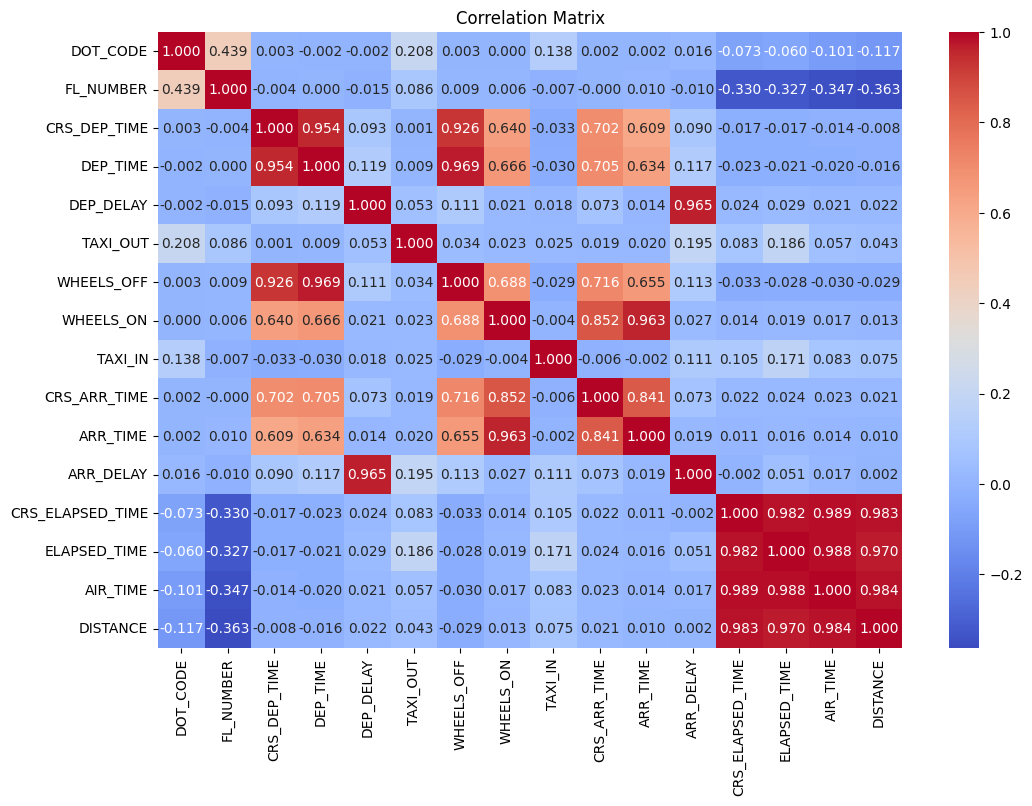

In [ ]:
numerical_df = df.select(numerical_fields).toPandas()

# compute the correlation matrix
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Correlation Matrix')
plt.show()


The same considerations as above are also visible from the pairwise scatter plots between the features.

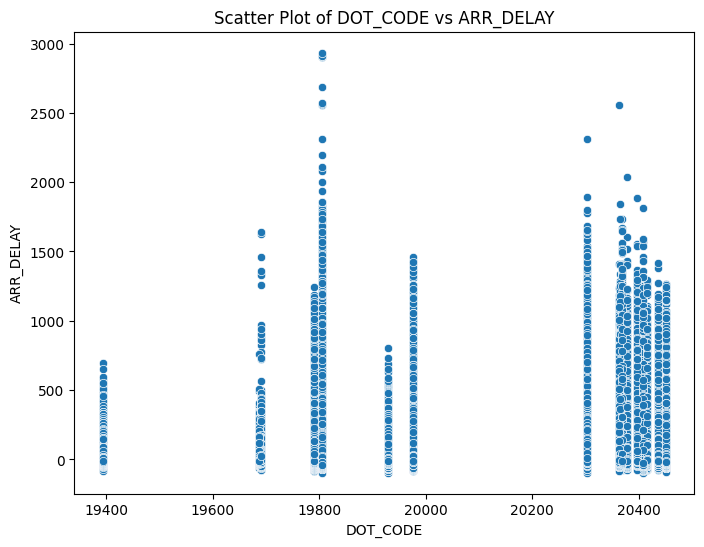

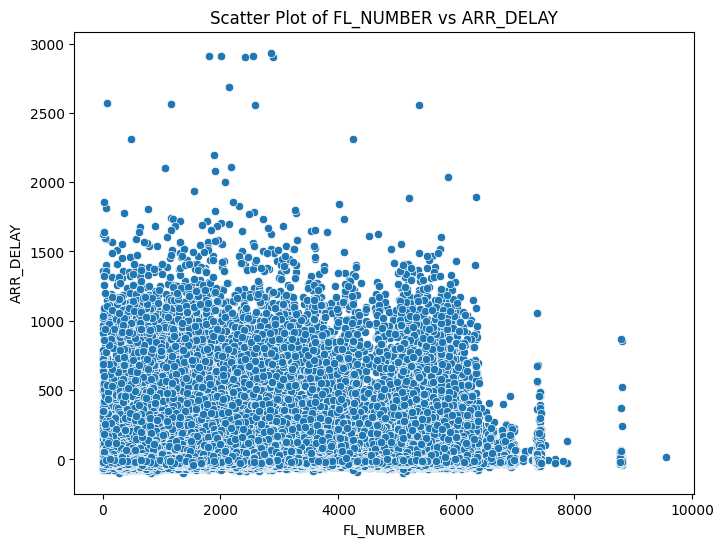

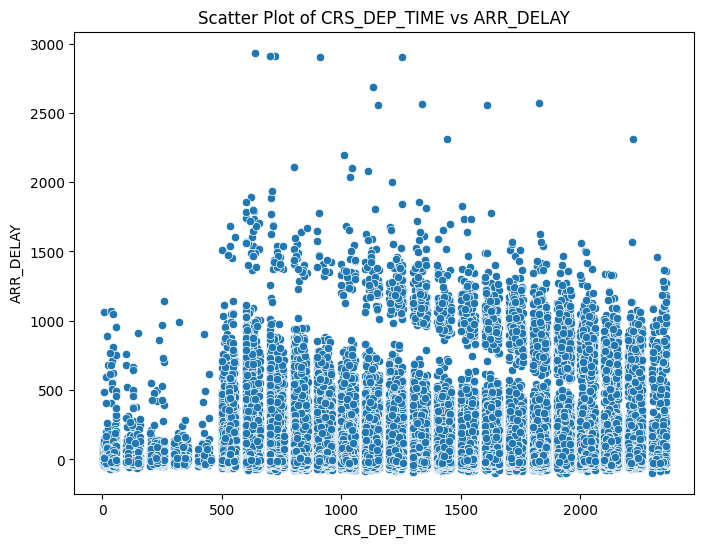

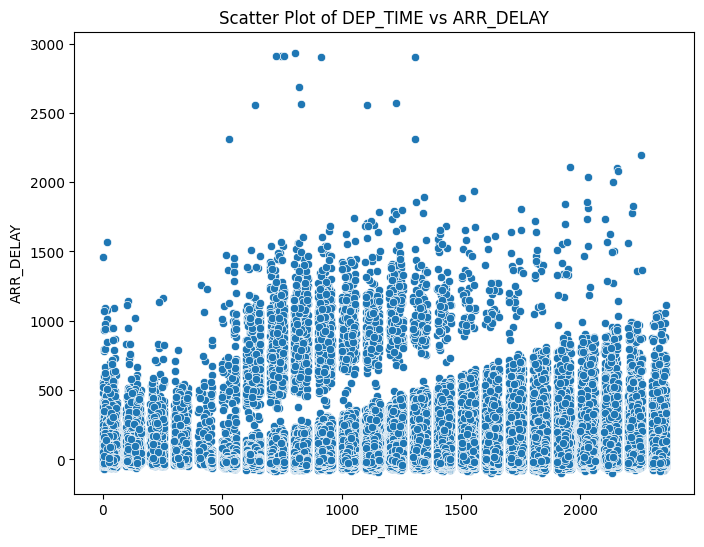

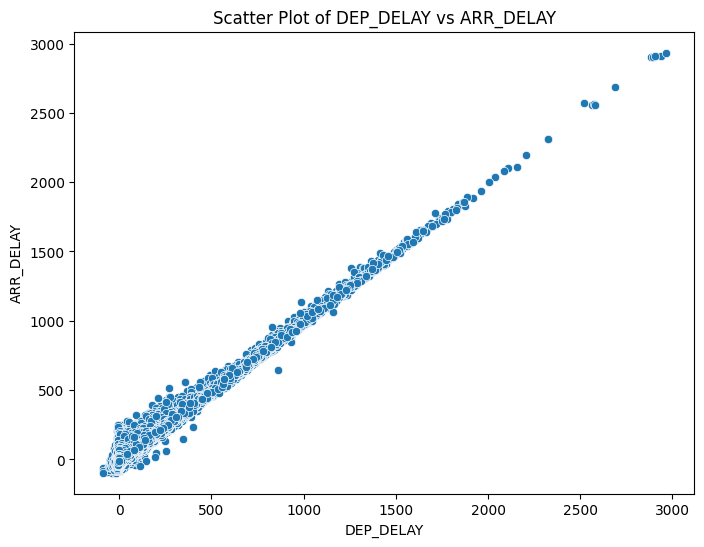

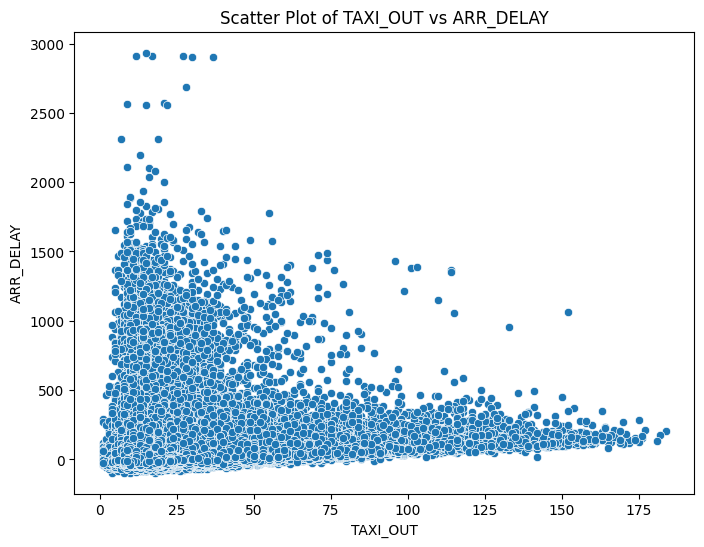

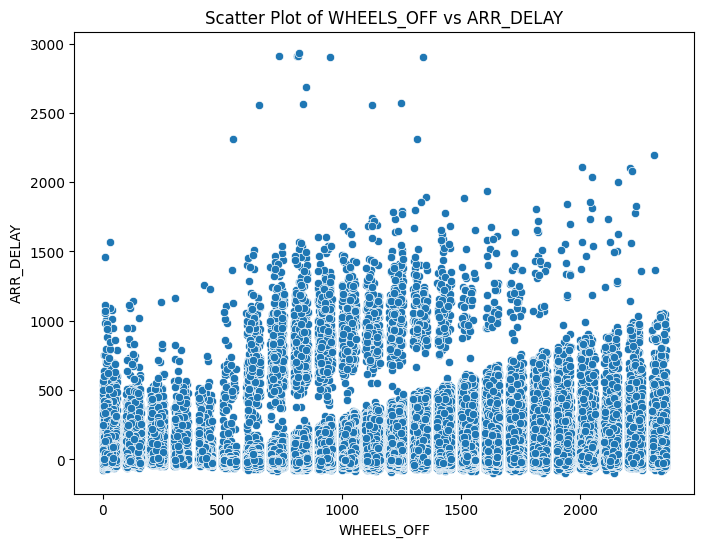

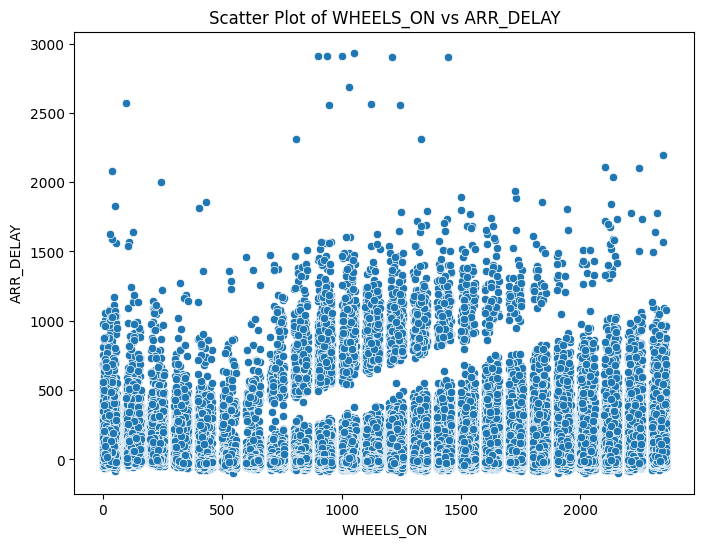

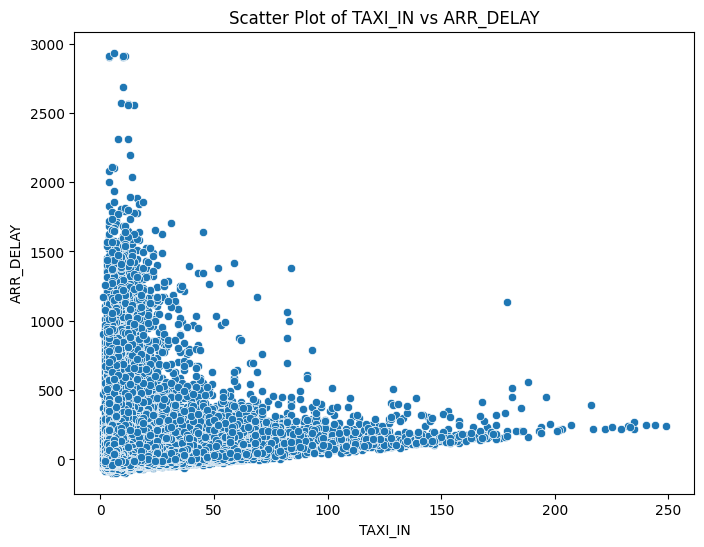

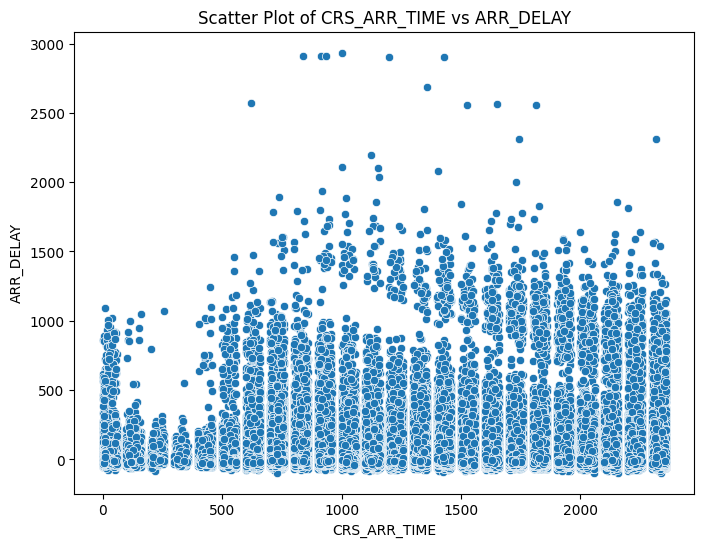

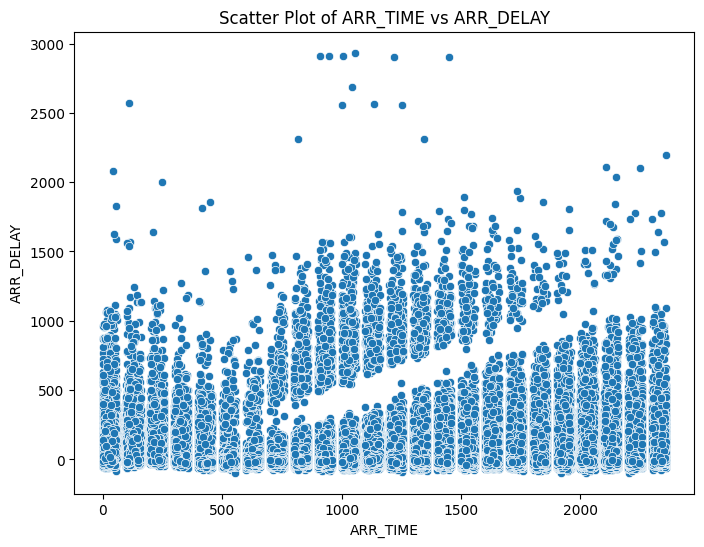

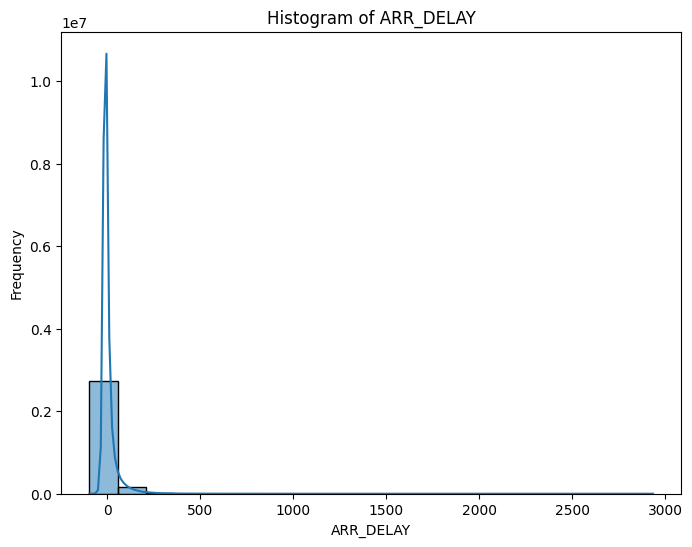

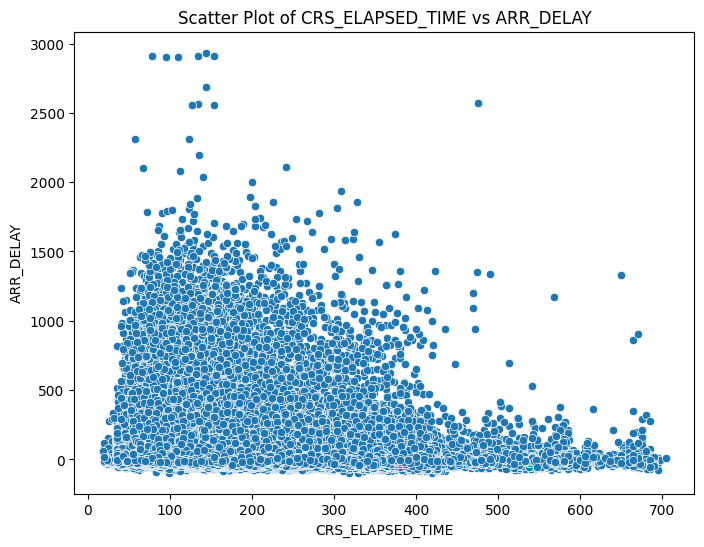

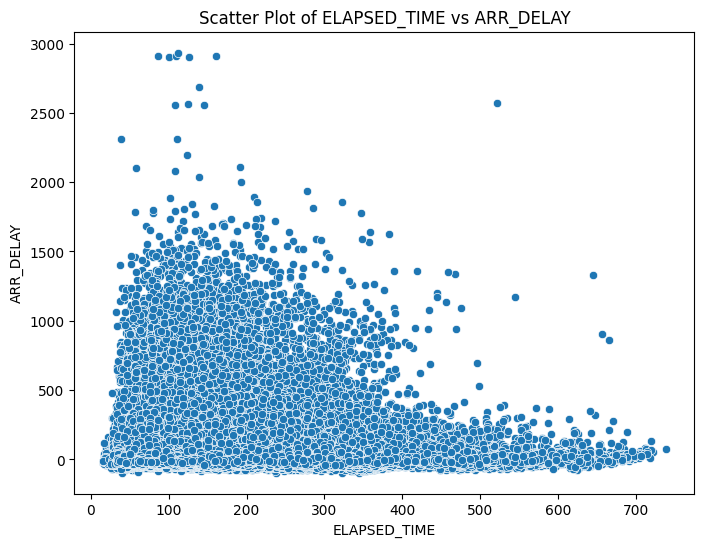

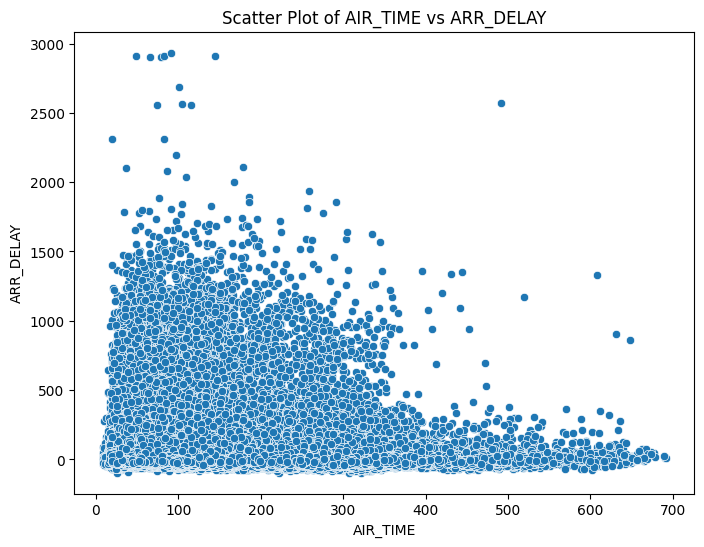

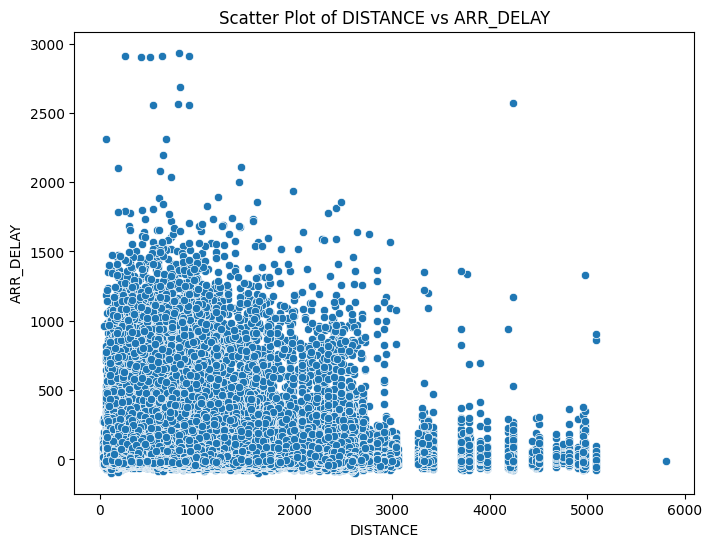

In [ ]:
#this is basically ARR_DELAY's row of seaborn's pairplot, which unfortunately makes the ram crash!
for column in numerical_fields:
    plt.figure(figsize=(8, 6))

    if column == 'ARR_DELAY':
        # kde was cool so I left it, despite fundamentally useless here
        sns.histplot(numerical_df[column], bins=20, kde=True)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
    else:
        sns.scatterplot(x=numerical_df[column], y=numerical_df['ARR_DELAY'])
        plt.title(f'Scatter Plot of {column} vs ARR_DELAY')
        plt.xlabel(column)
        plt.ylabel('ARR_DELAY')

    plt.show()


Moreover, the following bar chart highlights the similarity between distributions of the departure delay and the arrival delay.

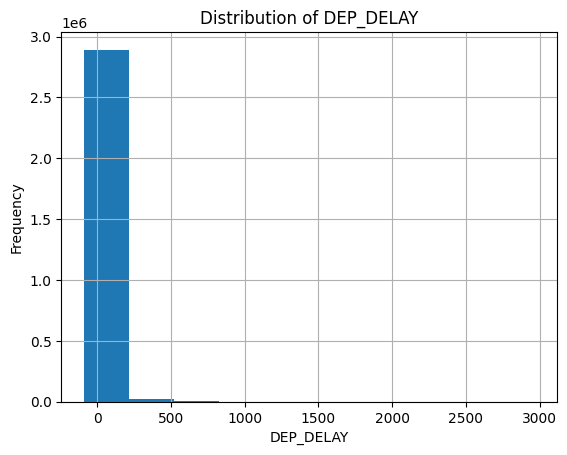

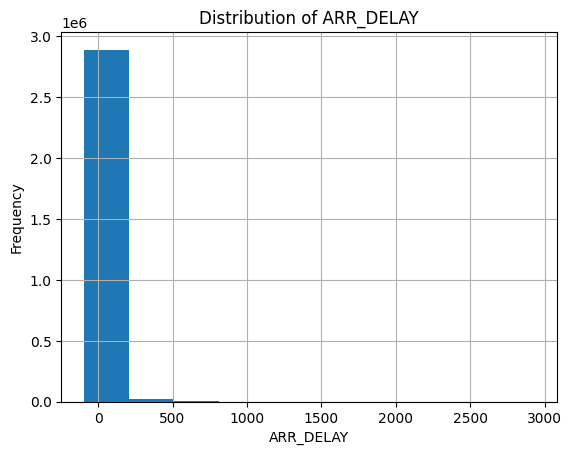

In [ ]:
for column in ["DEP_DELAY", "ARR_DELAY"]:
    numerical_df[column].hist(bins=10)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()


<h4>Nonnumerical features</h4>

By computing the average arrival delay for each value of the categorical features, there seems to be no great relationship between them. There is in fact little distance between top 10 and bottom 10 values for all the features. The greatest visible difference in the plots is the one of the dates, which are however the most sparse field.

In [ ]:
non_numerical_fields = [field[0] for field in df.dtypes if (field[1] == 'string' or field[1] == 'date')]
non_numerical_df = df.select("ARR_DELAY", *non_numerical_fields).toPandas()

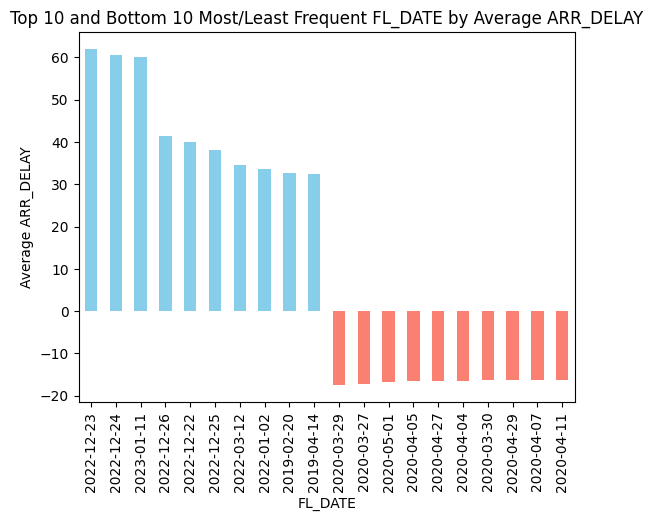

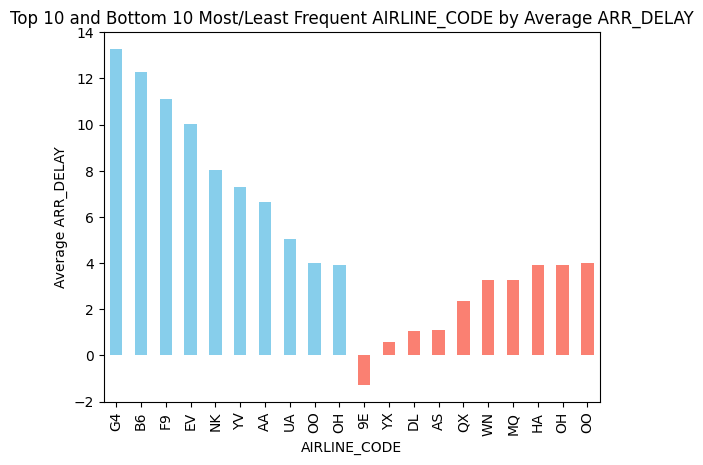

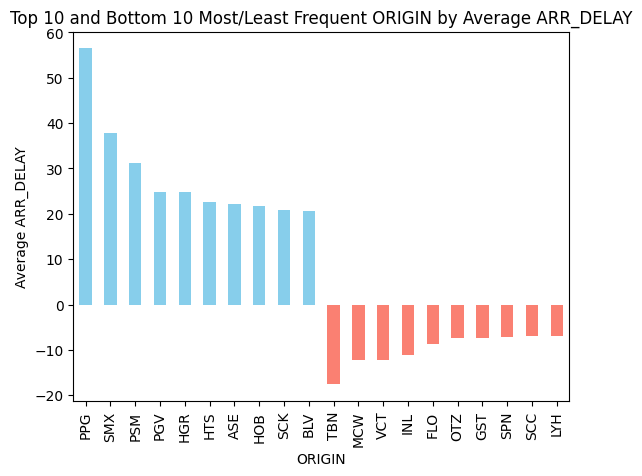

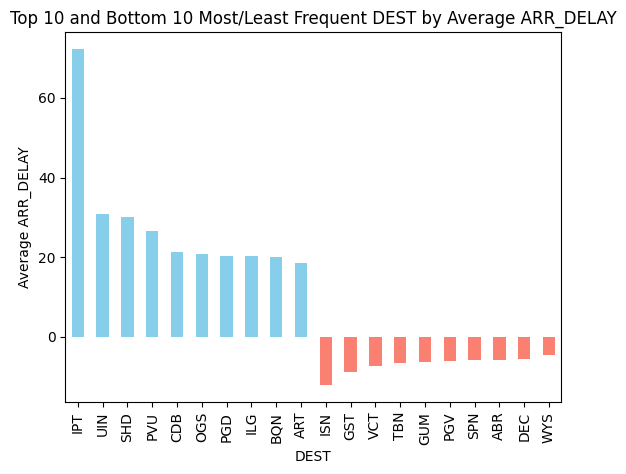

In [ ]:
top_n = 10

for column in non_numerical_fields:
    # average ARR_DELAY for each column
    avg_arr_delay = non_numerical_df.groupby(column)['ARR_DELAY'].mean()

    top_values = avg_arr_delay.nlargest(top_n)
    flop_values = avg_arr_delay.nsmallest(top_n)

    # concatenate top and bottom values
    combined_values = pd.concat([top_values, flop_values])

    # thanks gpt for nice colors
    combined_values.plot(kind='bar', color=['skyblue' if i < top_n else 'salmon' for i in range(len(combined_values))])
    plt.title(f'Top {top_n} and Bottom {top_n} Most/Least Frequent {column} by Average ARR_DELAY')
    plt.xlabel(column)
    plt.ylabel("Average ARR_DELAY")
    plt.show()


<h2> Data preprocessing </h2>

I combined the data into a numerical feature, like the times. In addition, I preprocessed the categorical features using the combination of StringIndexer and OneHotEncoder. Finally I selected the features for the feature vector, to train the ML models.
I selected:


*   FL_DATE, AIRLINE_CODE, ORIGIN, DEST: they may contain useful information: certain dates could be particularly problematic for flights, specific air routes could be more influenced by high traffic and some airlines could be just more prone to delays than others.
*   DOT_CODE, FL_NUMBER: despite the DOT_CODE contains the same information as the AIRLINE_CODE, it is encoded in a different way. The flight number again describes specific air routes.
*   CRS_DEP_TIME, CRS_ARR_TIME, CRS_ELAPSED_TIME, ELAPSED_TIME, DISTANCE: these fields provide useful information about air routes and are certainly useful to understand why delays occur.
*   DEP_TIME, DEP_DELAY, TAXI_IN, TAXI_OUT: these fields are the most correlated ones with ARR_DELAY, together with WHEELS_OFF, which can however be computed using DEP_TIME and TAXI_OUT.

I removed:
*   ARR_TIME, WHEELS_OFF: the first would have allowed to calculate ARR_DELAY, the latter would have allowed to calculate ARR_TIME itself. I was uncertain about keeping TAXI_IN, because this would not probably be present in a real-world on-line estimation. However, it could probably be predicted from historical data, therefore I kept it in the data for the model.

*   WHEELS_ON, AIR_TIME: these feature are redundant, as the both can be calculated with the input data.


In [ ]:
df = df.withColumn("FL_DATE", F.year("FL_DATE") * 10000 + F.month("FL_DATE") * 100 + F.dayofmonth("FL_DATE"))
df.show()

+--------+------------+--------+---------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+----------------+------------+--------+--------+--------------------+
| FL_DATE|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|         ARR_DELAY_Z|
+--------+------------+--------+---------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+----------------+------------+--------+--------+--------------------+
|20190109|          UA|   19977|     1562|   FLL| EWR|        1155|  1151.0|     -4.0|    19.0|    1210.0|   1443.0|    4.0|        1501|  1447.0|    -14.0|           186.0|       176.0|   153.0|  1065.0| -0.3569165552194029|
|20221119|          DL|   19790|     1149|   MSP| SEA|        2120|  2114.0|     -6.0|     9.0| 

In [ ]:

# index categorical columns
airline_indexer = StringIndexer(inputCol="AIRLINE_CODE", outputCol="AIRLINE_CODE_INDEX")
origin_indexer = StringIndexer(inputCol="ORIGIN", outputCol="ORIGIN_INDEX")
dest_indexer = StringIndexer(inputCol="DEST", outputCol="DEST_INDEX")


# one-hot encode indexed columns
airline_encoder = OneHotEncoder(inputCol="AIRLINE_CODE_INDEX", outputCol="AIRLINE_CODE_VEC")
origin_encoder = OneHotEncoder(inputCol="ORIGIN_INDEX", outputCol="ORIGIN_VEC")
dest_encoder = OneHotEncoder(inputCol="DEST_INDEX", outputCol="DEST_VEC")

# select feature fields
features_fields = ['FL_DATE', 'AIRLINE_CODE_VEC', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN_VEC', 'DEST_VEC', 'CRS_DEP_TIME', 'DEP_TIME',
                   'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'DISTANCE']


# create feature vector
assembler = VectorAssembler(inputCols=features_fields, outputCol="features")
# standardizes the feature vector
scaler = StandardScaler(inputCol="features", outputCol="features_scaled")


# allows to apply all the stages at once
pipeline = Pipeline(stages=[airline_indexer, origin_indexer, dest_indexer,
                            airline_encoder, origin_encoder, dest_encoder, assembler, scaler])

# add an index to later join with the predictions
df = df.withColumn("index", F.monotonically_increasing_id())

# create the dataset by specifying the target of the binary classifcation
dataset = df.withColumn("target", F.when(F.col("ARR_DELAY") > 15, 1).otherwise(0))
# apply the transformations to cathegorical fields
dataset = pipeline.fit(dataset).transform(dataset)

# the dataset contains: standardized features, labels and an index for the tuples
dataset = dataset.select("features_scaled", "target", "index")
dataset.show(truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+-----+
|features_scaled                                                                                                                                                                                                                                                                                                                                             |target|index|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<h2> Model Development </h2>

I developed the four suggested models. I used a seed for experiment repeatibility.

My approach consisted in trying to store as much data as possible in google drive, to support also separate executions of needed models, later merging the results. Anyway, it is still possible to run all the models at once.

Unfortunately, despite a reasonable choice (in my opinion) for the hyperparameters, the GBT and MLP did not terminate their training after >12 hours due to the huge size of the dataset. Hence, despite including them in the code, they will be excluded from the analysis.

In [ ]:
# test the code with very little dataset
#dataset = dataset.limit(100)
#print(dataset.count())

In [ ]:
seed = 17

# split train and test sets
train, test = dataset.randomSplit([0.8, 0.2], seed=seed)

# define models
model_names = ["Logistic Regression", "Random Forest", "Gradient Boosted Trees", "Multilayer Perceptron"]

# I will put the models in a dictionary to work with all of them at once
models = defaultdict(lambda: {})

# initialize the classes of the models
for name in model_names:
    if name == "Logistic Regression":
        models[name]["model"] = LogisticRegression(featuresCol="features_scaled", labelCol="target")

    elif name == "Random Forest":
        models[name]["model"] = RandomForestClassifier(featuresCol="features_scaled", labelCol="target", seed=seed)

    elif name == "Gradient Boosted Trees":
        models[name]["model"] = GBTClassifier(featuresCol="features_scaled", labelCol="target", seed=seed)

    elif name == "Multilayer Perceptron":
        models[name]["model"] = MultilayerPerceptronClassifier(featuresCol="features_scaled", labelCol="target", seed=seed)
        #print(models[name]["model"].explainParams())

Here I tuned the hyperparameters using the required 5-fold cross validation in the hyperparameter grid search. I tried to cover various order of growths, yet making feasible choices. Due to their longer running time, for Gradient-Boosted Trees and Multilayer Perceptron I could tune only one hyperparameter, therefore I selected I believe the most impactful ones: the maximum depth of the trees for the first and the layers' structure for the latter.

In [ ]:
# define the evaluator for training, using the area under the ROC curve
evaluator = BinaryClassificationEvaluator(labelCol="target", metricName="areaUnderROC")
for name in model_names:
    start_time = time()
    # initialize the parameters grids
    if name == "Logistic Regression":
        models[name]["params"] = (ParamGridBuilder()
                                  .addGrid(models[name]["model"].regParam, [0.01, 0.1, 1])
                                  .addGrid(models[name]["model"].elasticNetParam, [0.0, 0.5, 1.0])
                                  .build())
    elif name == "Random Forest":
        models[name]["params"] = (ParamGridBuilder()
                                  .addGrid(models[name]["model"].numTrees, [10, 20])
                                  .addGrid(models[name]["model"].maxDepth, [5, 10, 20])
                                  .build())
    elif name == "Gradient Boosted Trees":
        models[name]["params"] = (ParamGridBuilder()
                                  .addGrid(models[name]["model"].maxDepth, [5, 10, 20])
                                  .build())
    elif name == "Multilayer Perceptron":
        models[name]["params"] = (ParamGridBuilder()
                                  .addGrid(models[name]["model"].layers, [[787, 100, 2], [787, 100, 10, 2], [787, 10, 10, 10, 2]])
                                  .build())
    # create the cross validation object
    cv = CrossValidator(estimator=models[name]["model"], estimatorParamMaps=models[name]["params"],
                        evaluator=evaluator, numFolds=5, seed=seed)

    # apply cross validation, choose the best model and store it
    models[name]["model"] = cv.fit(train).bestModel
    file_name = "_".join(name.lower().split())
    models[name]["model"].write().overwrite().save(dir_path + file_name)

    elapsed_time = time() - start_time
    print(f"{name} model trained and saved after {elapsed_time / (60 * 60)} hours")



Logistic Regression model trained and saved after 1.0065551030635833 hours
Random Forest model trained and saved after 4.625281346042951 hours


In [ ]:
# print the best hyperparameters and store them in a file
with open(dir_path + "best_hyperparameters.txt", "w", encoding="utf-8") as f:
    for name in model_names:
        best_params = f"Best Hyperparameters for {name}: "
        if name == "Logistic Regression":
            best_params += f"regParam: {models[name]['model'].getRegParam()}, elasticNetParam: {models[name]['model'].getElasticNetParam()}"
        elif name == "Random Forest":
            # btw why the hell isn't that a method?
            best_params += f"numTrees: {models[name]['model'].getNumTrees}, maxDepth: {models[name]['model'].getMaxDepth()}"
        elif name == "Gradient Boosted Trees":
            best_params += f"maxDepth: {models[name]['model'].getMaxDepth()}"
        elif name == "Multilayer Perceptron":
            best_params += f"layers: {models[name]['model'].getLayers()}"
        print(best_params)
        f.write(best_params + "\n")


Best Hyperparameters for Logistic Regression: regParam: 0.01, elasticNetParam: 0.0
Best Hyperparameters for Random Forest: numTrees: 20, maxDepth: 20


In [ ]:
# reload the models from their checkpoints
for name in model_names:
    file_name = "_".join(name.lower().split())
    if name == "Logistic Regression":
        models[name]["model"] = LogisticRegressionModel.load(dir_path + file_name)
    elif name == "Random Forest":
        models[name]["model"] = RandomForestClassificationModel.load(dir_path + file_name)
    elif name == "Gradient Boosted Trees":
        models[name]["model"] = GBTClassificationModel.load(dir_path + file_name)
    elif name == "Multilayer Perceptron":
        models[name]["model"] = MultilayerPerceptronClassificationModel.load(dir_path + file_name)

In this block I applied the best model to the test set, gathering all the required metrics using the appropriate classes.

In [ ]:
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="target", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="target", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="target", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="target", metricName="f1")
evaluator = BinaryClassificationEvaluator(labelCol="target", metricName="areaUnderROC")

for name in model_names:
    models[name]["predictions"] = models[name]["model"].transform(test)
    auc = evaluator.evaluate(models[name]["predictions"])
    accuracy = accuracy_evaluator.evaluate(models[name]["predictions"])
    precision = precision_evaluator.evaluate(models[name]["predictions"])
    recall = recall_evaluator.evaluate(models[name]["predictions"])
    f1 = f1_evaluator.evaluate(models[name]["predictions"])

    results_dict = {
        "Model": name,
        "AUC": auc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }
    models[name]["performance"] = results_dict

    results = f"{name} - AUC: {auc}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}"
    print(results)


Logistic Regression - AUC: 0.9796727924443751, Accuracy: 0.9316252531968519, Precision: 0.9354804788597282, Recall: 0.9316252531968519, F1 Score: 0.9252565760291044
Random Forest - AUC: 0.9637573672811744, Accuracy: 0.9098988587028418, Precision: 0.9144280275012406, Recall: 0.9098988587028418, F1 Score: 0.8983777521730572


Let's check out some predictions

In [ ]:
models['Logistic Regression']['predictions'].show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+------+------------------------------------------+------------------------------------------+----------+
|features_scaled                                                                                                                                                                                                                                                                                                                                         |target|index |rawPrediction                             |probability                               |prediction|
+-----------------------------------------------------------------------------------

Here I computed the confusion matrix for all models and I plotted it using a heatmap. It is clear that, due to the unbalanced dataset, where samples with ARR_DELAY <15 minutes are much more present, most errors are false negatives.

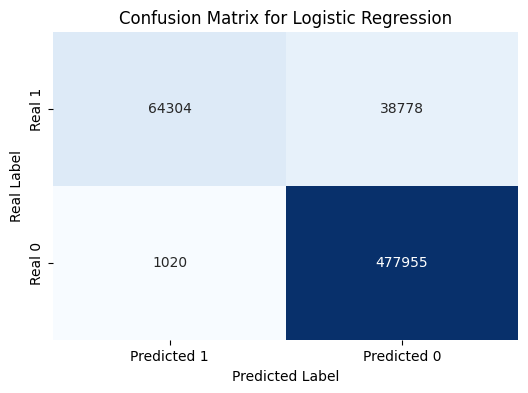

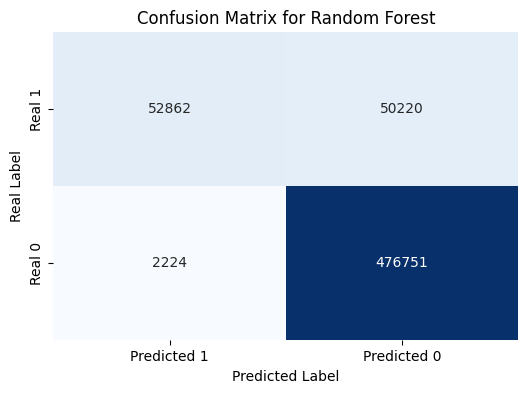

In [ ]:
# Funzione per visualizzare la matrice di confusione
def plot_confusion_matrix(confusion_matrix, model_name="model"):
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Predicted 1", "Predicted 0"],
                yticklabels=["Real 1", "Real 0"])
    plt.xlabel("Predicted Label")
    plt.ylabel("Real Label")
    plt.title(f"Confusion Matrix for {model_name}")

    file_name = "_".join(model_name.lower().split())
    plt.savefig(dir_path + f"confusion_matrix_{file_name}.png")
    plt.show()

def compute_confusion_matrix(predictions, labelCol="target", predictionCol="prediction"):
    # Compute TP, TN, FP, FN
    tp = predictions.filter((F.col(labelCol) == 1) & (F.col(predictionCol) == 1)).count()
    tn = predictions.filter((F.col(labelCol) == 0) & (F.col(predictionCol) == 0)).count()
    fp = predictions.filter((F.col(labelCol) == 0) & (F.col(predictionCol) == 1)).count()
    fn = predictions.filter((F.col(labelCol) == 1) & (F.col(predictionCol) == 0)).count()

    # Display the confusion matrix
    confusion_matrix = [[tp, fn], [fp, tn]]

    return confusion_matrix

for name in model_names:
    confusion_matrix = compute_confusion_matrix(models[name]["predictions"])
    plot_confusion_matrix(confusion_matrix, model_name=name)

As expected, the most important feature for the random forest is DEP_DELAY and also the other more correlated features with ARR_DELAY (like TAXI_OUT and DEP_TIME) have a higher importance than the others.

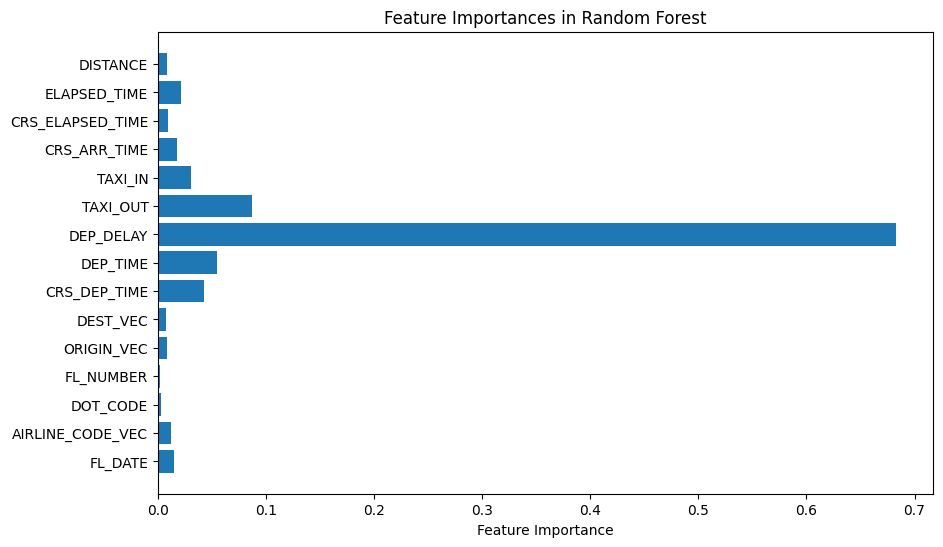

In [ ]:
def plot_feature_importances(feature_importances, features, model_name = "model"):
    # store aggregated feature importances for one-hot encoded features
    aggregated_importances = []
    start_idx = 0

    for feature in features_fields:
        # one-hot encoded features end with 'VEC'
        if feature.endswith("VEC"):
            # count all distinct values of the feature
            num_categories = df.select(feature[:-4]).distinct().count()
            end_idx = start_idx + num_categories - 1
            # sum the importance of all dimensions of the feature
            aggregated_importances.append(sum(feature_importances[start_idx:end_idx]))
            start_idx = end_idx
        else:
            # if it's a non-one-hot feature, just take its importance
            aggregated_importances.append(feature_importances[start_idx])
            start_idx += 1

    file_name = "_".join(model_name.lower().split())
    plt.figure(figsize=(10, 6))
    plt.barh(features_fields, aggregated_importances)
    plt.xlabel("Feature Importance")
    plt.title(f"Feature Importances in {model_name}")
    plt.savefig(dir_path + f"{file_name}_feature_importances.png")
    plt.show()

for name in ["Random Forest", "Gradient Boosted Trees"]:
    feature_importances = models[name]["model"].featureImportances.toArray()
    plot_feature_importances(feature_importances, features_fields, model_name=name)

From the ROC curve it is clear that both model converged, however logistic regression seemed to work slightly better.

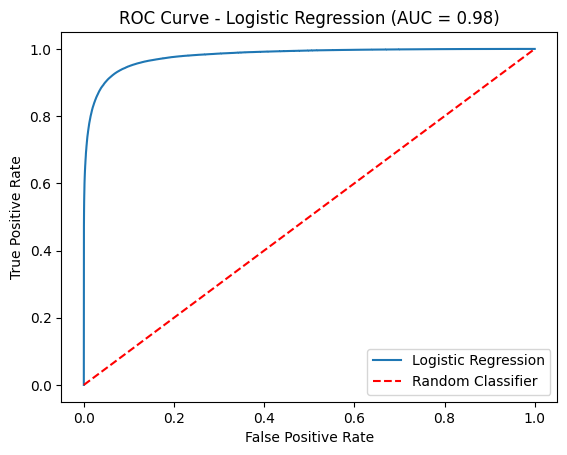

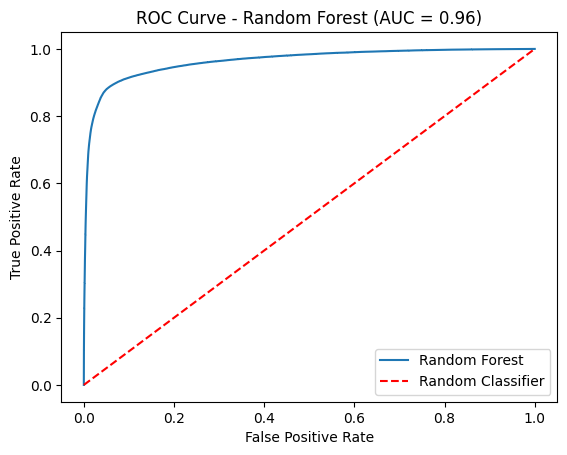

In [ ]:
def plot_roc_curve(predictions, model_name="model", labelCol="target", probabilityCol="probability"):
    pred = predictions.select(probabilityCol, labelCol).collect()
    points = [(p[probabilityCol][1], p[labelCol]) for p in pred]
    y_score, y_true = zip(*points)

    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, label=f'{model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # diagonal line for random classifier
    plt.plot([0, 1], [0, 1], 'r--', label="Random Classifier")

    plt.title(f'ROC Curve - {model_name} (AUC = {evaluator.evaluate(predictions):.2f})')
    plt.legend(loc="lower right")
    file_name = "_".join(model_name.lower().split())
    plt.savefig(dir_path + f"roc_curve_{file_name}.png")
    plt.show()

for name in model_names:
    plot_roc_curve(models[name]["predictions"], model_name=name)

The results of both models are quite satisfying and reflect the above considerations about the ROC curve. It is clear that the logistic regression is slightly more accurate.

In [ ]:
performance_data = [models[name]["performance"] for name in model_names]

results_df = pd.DataFrame(performance_data)

# remove automatic dataframe index
results_df.set_index("Model", inplace=True)

print(results_df)

results_df.to_csv(dir_path + "model_performance_results.csv")


                          AUC  Accuracy  Precision    Recall  F1 Score
Model                                                                 
Logistic Regression  0.979673  0.931625   0.935480  0.931625  0.925257
Random Forest        0.963758  0.909899   0.914428  0.909899  0.898378


<h2>Evaluation of the mistakes </h2>

Here I store the errors in a csv file for more accurate analysis. I also tried to guess some reasons for the mistakes of the model. Logistic regression is quite robust to outliers, which are always classified correctly. Conversely, the random forest errors have a higher presence of outliers than the dataset itself, demonstrating less robustness with respect to these samples.

Furthermore, in the mistakes of the logistic regression's predictions ARR_DELAY and DEP_DELAY have a much lower correlation than in the whole dataset, showing that the model heavily relies on this field to predict the other. Conversely, the random forest errors have a comparable correlation, so they seem to rely less on this field, despite being the one with the highest importance.

+-----+--------+------------+--------+---------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+----------------+------------+--------+--------+--------------------+----------+------+
|index| FL_DATE|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|         ARR_DELAY_Z|prediction|target|
+-----+--------+------------+--------+---------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+----------------+------------+--------+--------+--------------------+----------+------+
|    3|20230306|          DL|   19790|     2295|   MSP| SFO|        1609|  1608.0|     -1.0|    27.0|    1635.0|   1844.0|    9.0|        1829|  1853.0|     24.0|           260.0|       285.0|   249.0|  1589.0|  0.3859206579669707|       0.0|     1|


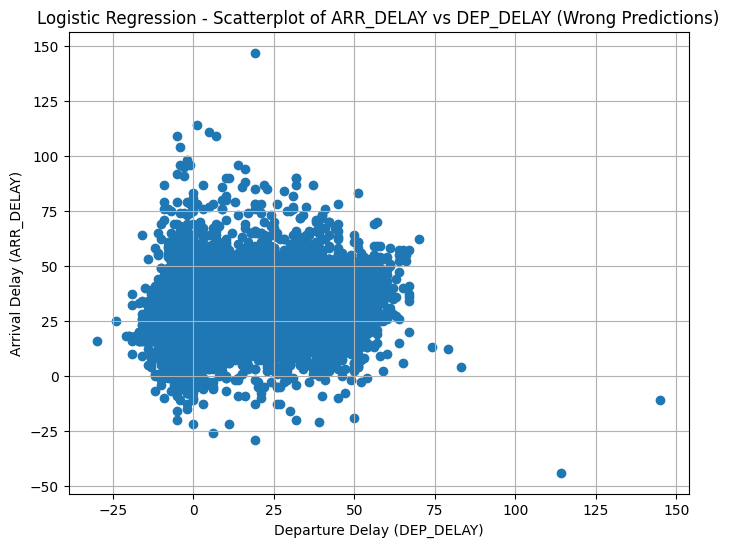

+-----+--------+------------+--------+---------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+----------------+------------+--------+--------+-------------------+----------+------+
|index| FL_DATE|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|        ARR_DELAY_Z|prediction|target|
+-----+--------+------------+--------+---------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+----------------+------------+--------+--------+-------------------+----------+------+
|    3|20230306|          DL|   19790|     2295|   MSP| SFO|        1609|  1608.0|     -1.0|    27.0|    1635.0|   1844.0|    9.0|        1829|  1853.0|     24.0|           260.0|       285.0|   249.0|  1589.0| 0.3859206579669707|       0.0|     1|
|   

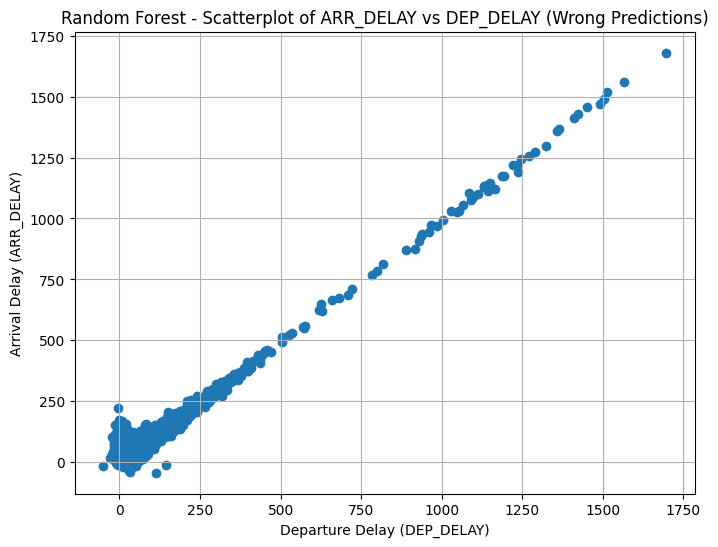

In [ ]:
with open(dir_path + "wrong_report.txt", "w", encoding="utf-8") as f:
    for name in model_names:
        # join the predictions with the dataframe to recover the original data
        results = df.join(models[name]["predictions"].select("index", "prediction", "target"), on="index", how="inner")

        # filter on wrong predictions
        wrong = results.filter(F.col("prediction") != F.col("target"))

        # check them out
        wrong.show()

        # check the proportion of outliers
        wrong_outliers = wrong.filter(F.col("ARR_DELAY_Z") > 3).count()
        wrong_number = wrong.count()
        report = f"{name} - proportion of outliers in wrong predictions: {wrong_outliers}/{wrong_number} ({wrong_outliers/wrong_number*100:.2f}%)"
        print(report)
        f.write(report + "\n")

        correlation = wrong.stat.corr("ARR_DELAY", "DEP_DELAY")
        report  = f"{name} - Correlation between ARR_DELAY and DEP_DELAY among wrong predictions: {correlation:.2f}"
        print(report)
        f.write(report + "\n")

        file_name = "_".join(name.lower().split())

        # ram should be enough to store the very few errors of my models... right? :)
        wrong_pd = wrong.toPandas()

        # Scatterplot
        plt.figure(figsize=(8, 6))
        plt.scatter(wrong_pd["DEP_DELAY"], wrong_pd["ARR_DELAY"])
        plt.title(f"{name} - Scatterplot of DEP_DELAY vs ARR_DELAY (Wrong Predictions)")
        plt.xlabel("Departure Delay (DEP_DELAY)")
        plt.ylabel("Arrival Delay (ARR_DELAY)")
        plt.grid(True)
        plt.savefig(dir_path + f"wrongs_scatterplot_{file_name}_depdelay_arrdelay.png")
        plt.show()


        wrong_pd.to_csv(dir_path + f"wrong_predictions_{file_name}.csv")


In [ ]:
spark.stop()